## set running directory to project source

In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
from pkg.utils.code_scraps import add_indy_sweep_tool, \
        use_current_place_point_only, use_current_sub_binders_only, \
        finish_L_shape, set_l_shape_object, ModeSwitcher, double_sweep_motions

from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene
from pkg.planning.pipeline import PlanningPipeline
from pkg.ui.ui_broker import *
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask, AbstractObject
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.planning.constraint.constraint_subject import SweepFrame
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.task.rrt import TaskRRT
from pkg.planning.constraint.constraint_common import sample_redundancy, combine_redundancy
from pkg.planning.sampling.node_sampling import make_state_param_hashable, UniformNodeSampler, PenaltyNodeSampler, GrowingSampler
from pkg.planning.task.custom_rules.sweep_entrance_control import SweepEntranceControlRule
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import defaultdict
from demo_utils.area_select import DATASET_DIR

## Set Parameters

In [2]:
ROBOT_TYPE = RobotType.indy7
TIMEOUT_MP = 0.5

R_be = Rot_rpy([np.pi, np.pi/2, 0])

X_range = (-1, -0.3)
Y_range = (-1, 1)
Z_range = (0.0, 0.7)
X_step = 0.02
Y_step = 0.01
Z_step = 0.02

SWEEP_AXIS = "Y"

N_try = 3
SWEEP_DIV = 10


DATASET_PATH = os.path.join(DATASET_DIR, ROBOT_TYPE.name+'.npy')

## create scene builder

In [3]:
robot_config = RobotConfig(0, ROBOT_TYPE, ((0.0,0.0,0), (0,0,0)), INDY_IP)

crob = CombinedRobot(robots_on_scene=[robot_config], connection_list=[False])

ROBOT_NAME = robot_config.get_indexed_name()
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

connection command:
indy0: False


## make geometry scene

In [4]:
BASE_LINK = "base_link"
EE_NAME = "ee_point"
gscene = s_builder.create_gscene(crob, start_rviz=True)

floor = gscene.create_safe(GEOTYPE.BOX, "floor", BASE_LINK, (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
# ee_point.draw_traj_coords([[0]*6])

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## init planning pipeline

In [5]:
pscene = PlanningScene(gscene, combined_robot=crob)
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
ee_point = gscene.create_safe(GEOTYPE.SPHERE, EE_NAME, TIP_LINK, (0.01,)*3, 
                              center=(0,0,0), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.8), display=True, fixed=True, collision=False)

ppline = PlanningPipeline(pscene)

mplan = MoveitPlanner(pscene)
mplan.update_gscene()
ppline.set_motion_planner(mplan)


# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


## Scan

In [6]:
VISUALIZE = False
VERBOSE = True

 * Environment: production
   Use a production WSGI server instead.


In [7]:
gtimer = GlobalTimer.instance()
gtimer.reset()

X_DIR, Y_DIR, Z_DIR = np.identity(3, dtype=np.int)
SWEEP_AX_IDX = "xyz".find(SWEEP_AXIS.lower())
SWEEP_DIR = [X_DIR, Y_DIR, Z_DIR][SWEEP_AX_IDX]
RANGE_STEPS_REF = [(X_range, X_step, X_DIR), (Y_range, Y_step, Y_DIR), (Z_range, Z_step, Z_DIR)]
RANGE_STEPS = np.array(RANGE_STEPS_REF)[np.where(np.logical_not(SWEEP_DIR))]
RANGE1, STEP1, DIR1 = RANGE_STEPS[0]
RANGE2, STEP2, DIR2 = RANGE_STEPS[1]
RANGEX, STEPX, DIRX = RANGE_STEPS_REF[SWEEP_AX_IDX]
STEP_SWEEP = float(RANGEX[1] - RANGEX[0])/SWEEP_DIV

range_list_dict = {}
STEPS_1 = np.round(np.arange(RANGE1[0], RANGE1[1]+STEP1, STEP1), 4)
STEPS_2 = np.round(np.arange(RANGE2[0], RANGE2[1]+STEP2, STEP2), 4)
STEPS_X = np.round([0] + np.arange(RANGEX[0], RANGEX[1]-1e-3, STEP_SWEEP)[1:].tolist(), 4)
LEN_1, LEN_2 = len(STEPS_1), len(STEPS_2)
count = 0
LEN_ALL = LEN_1*LEN_2
gtimer.tic("test")
for i_p1, pos1 in enumerate(STEPS_1):
    for i_p2, pos2 in enumerate(STEPS_2):
        count += 1
        with gtimer.block("loop"):
            pos0 = np.multiply(pos1, DIR1) + np.multiply(pos2, DIR2)
            key = tuple(np.round(pos0, 4))
            print("========= {} ({}/{})=========".format(key, count, LEN_ALL))
            T_be = SE3(R_be, pos0)
            for _ in range(N_try):
                traj, success = mplan.planner.plan_py(
                    ROBOT_NAME, TIP_LINK, np.concatenate(T2xyzquat(T_be)), BASE_LINK, np.zeros(gscene.joint_num), 
                    timeout=TIMEOUT_MP)

                if success:
                    break
            if not success:
                continue
            p2p_list = []
            for i_px, posx in enumerate(STEPS_X):
                pos_sweep = np.multiply(posx, DIRX)
                pos = pos0 + pos_sweep
                T_be = SE3(R_be, pos)
                if i_px > 0: # already done for 0
                    if abs(posx) < 1e-4: # already done for 0 at 0 index
                        continue
                    traj, success = mplan.planner.plan_py(
                        ROBOT_NAME, TIP_LINK, np.concatenate(T2xyzquat(T_be)), BASE_LINK, np.zeros(gscene.joint_num), 
                        timeout=TIMEOUT_MP)
                if not success:
                    continue
                Q0 = traj[-1]
                if VISUALIZE:
                    gscene.show_pose(Q0)

                pos_tar = np.multiply(RANGEX[0], DIRX)
                dP_tar = pos_tar - pos_sweep
                Traj_down = get_sweep_traj(mplan, ee_point, dP_tar, Q0, DP=STEPX, ERROR_CUT=0.01, VISUALIZE=VISUALIZE, VERBOSE=VERBOSE)
                if len(Traj_down)==0:
                    continue
                Qdown = Traj_down[-1]

                pos_tar = np.multiply(RANGEX[1], DIRX)
                dP_tar = pos_tar - pos_sweep
                Traj_up = get_sweep_traj(mplan, ee_point, dP_tar, Q0, DP=STEPX, ERROR_CUT=0.01, VISUALIZE=VISUALIZE, VERBOSE=VERBOSE)
                if len(Traj_up)==0:
                    continue
                Qup = Traj_up[-1]

                p0 = ee_point.get_tf(list2dict(Q0, gscene.joint_names))[SWEEP_AX_IDX,3]
                pdown = ee_point.get_tf(list2dict(Qdown, gscene.joint_names))[SWEEP_AX_IDX,3]
                pup = ee_point.get_tf(list2dict(Qup, gscene.joint_names))[SWEEP_AX_IDX,3]
                p2p = (pdown, pup)
                if np.multiply(*np.sign(p2p))<0:
                    p2p_list.append(p2p)
            range_list_dict[key] = np.array(p2p_list)
    elapsed = gtimer.toc("test")/1000
    print(gtimer)
    print("=============================================")
    print("=============== {} / {} s===================".format(int(elapsed), int(elapsed/count*LEN_ALL)))

    print("=============================================")

 * Debug mode: off
========= (-1.0, 0.0, 0.0) (1/1296)=========
========= (-1.0, 0.0, 0.02) (2/1296)=========
========= (-1.0, 0.0, 0.04) (3/1296)=========
========= (-1.0, 0.0, 0.06) (4/1296)=========
========= (-1.0, 0.0, 0.08) (5/1296)=========
========= (-1.0, 0.0, 0.1) (6/1296)=========
joint max
joint max
i_px: 5
========= (-1.0, 0.0, 0.12) (7/1296)=========
joint max
joint max
joint max
joint max
i_px: 5
joint max
joint max
========= (-1.0, 0.0, 0.14) (8/1296)=========
joint max
joint max
joint max
joint max
i_px: 5
joint max
joint max
========= (-1.0, 0.0, 0.16) (9/1296)=========
joint max
joint min
joint max
joint min
i_px: 5
joint max
joint max
========= (-1.0, 0.0, 0.18) (10/1296)=========
joint max
joint max
joint max
joint max
i_px: 5
joint max
joint max
========= (-1.0, 0.0, 0.2) (11/1296)=========
joint max
joint max
joint max
joint max
i_px: 5
joint max
joint max
========= (-1.0, 0.0, 0.22) (12/1296)=========
joint max
joint max
joint max
joint max
i_px: 5
joint max
joi

========= (-0.96, 0.0, 0.46) (96/1296)=========
========= (-0.96, 0.0, 0.48) (97/1296)=========
========= (-0.96, 0.0, 0.5) (98/1296)=========
========= (-0.96, 0.0, 0.52) (99/1296)=========
========= (-0.96, 0.0, 0.54) (100/1296)=========
========= (-0.96, 0.0, 0.56) (101/1296)=========
singular
singular
joint min
singular
i_px: 5
joint min
singular
========= (-0.96, 0.0, 0.58) (102/1296)=========
singular
joint max
singular
joint max
i_px: 5
joint max
singular
========= (-0.96, 0.0, 0.6) (103/1296)=========
singular
joint max
singular
joint max
i_px: 5
joint min
singular
========= (-0.96, 0.0, 0.62) (104/1296)=========
singular
joint max
singular
joint max
i_px: 5
joint max
singular
========= (-0.96, 0.0, 0.64) (105/1296)=========
singular
singular
singular
joint max
i_px: 5
singular
singular
========= (-0.96, 0.0, 0.66) (106/1296)=========
singular
singular
singular
singular
i_px: 5
singular
singular
========= (-0.96, 0.0, 0.68) (107/1296)=========
singular
singular
i_px: 5
========

========= (-0.92, 0.0, 0.48) (169/1296)=========
========= (-0.92, 0.0, 0.5) (170/1296)=========
========= (-0.92, 0.0, 0.52) (171/1296)=========
========= (-0.92, 0.0, 0.54) (172/1296)=========
========= (-0.92, 0.0, 0.56) (173/1296)=========
========= (-0.92, 0.0, 0.58) (174/1296)=========
joint max
joint max
singular
singular
i_px: 5
joint max
error off
========= (-0.92, 0.0, 0.6) (175/1296)=========
singular
joint max
singular
singular
i_px: 5
singular
error off
========= (-0.92, 0.0, 0.62) (176/1296)=========
singular
joint min
singular
joint max
i_px: 5
joint min
joint min
========= (-0.92, 0.0, 0.64) (177/1296)=========
singular
joint max
singular
joint max
i_px: 5
singular
singular
========= (-0.92, 0.0, 0.66) (178/1296)=========
singular
joint max
singular
joint max
i_px: 5
joint min
singular
========= (-0.92, 0.0, 0.68) (179/1296)=========
error off
joint min
singular
joint max
i_px: 5
singular
singular
========= (-0.92, 0.0, 0.7) (180/1296)=========
singular
joint max
singul

joint min
joint max
i_px: 5
joint min
joint max
joint min
joint max
========= (-0.88, 0.0, 0.4) (237/1296)=========
joint min
singular
joint min
singular
singular
joint min
i_px: 5
joint min
singular
joint min
singular
========= (-0.88, 0.0, 0.42) (238/1296)=========
singular
joint min
joint min
joint min
joint max
joint min
i_px: 5
joint min
singular
joint max
joint max
========= (-0.88, 0.0, 0.44) (239/1296)=========
joint min
joint max
singular
joint min
joint min
singular
i_px: 5
joint min
joint max
joint min
joint max
========= (-0.88, 0.0, 0.46) (240/1296)=========
========= (-0.88, 0.0, 0.48) (241/1296)=========
========= (-0.88, 0.0, 0.5) (242/1296)=========
========= (-0.88, 0.0, 0.52) (243/1296)=========
========= (-0.88, 0.0, 0.54) (244/1296)=========
========= (-0.88, 0.0, 0.56) (245/1296)=========
========= (-0.88, 0.0, 0.58) (246/1296)=========
========= (-0.88, 0.0, 0.6) (247/1296)=========
========= (-0.88, 0.0, 0.62) (248/1296)=========
singular
joint max
error off
sin

========= (-0.84, 0.0, 0.28) (303/1296)=========
joint max
joint max
joint min
joint max
joint max
joint min
i_px: 5
joint min
joint max
joint min
singular
========= (-0.84, 0.0, 0.3) (304/1296)=========
joint min
joint max
joint max
joint min
joint max
joint min
i_px: 5
joint min
singular
joint min
singular
========= (-0.84, 0.0, 0.32) (305/1296)=========
joint max
joint max
joint max
joint max
joint min
joint max
i_px: 5
joint min
singular
joint min
singular
========= (-0.84, 0.0, 0.34) (306/1296)=========
singular
joint max
singular
joint min
joint min
singular
i_px: 5
joint min
singular
joint min
singular
========= (-0.84, 0.0, 0.36) (307/1296)=========
joint min
joint max
joint min
singular
singular
joint max
i_px: 5
joint min
singular
joint min
error off
========= (-0.84, 0.0, 0.38) (308/1296)=========
joint min
joint max
singular
joint max
joint max
joint min
i_px: 5
joint min
joint max
joint min
joint max
========= (-0.84, 0.0, 0.4) (309/1296)=========
joint min
singular
singul

========= (-0.8, 0.0, 0.14) (368/1296)=========
joint max
joint min
joint max
joint min
collision
joint max
i_px: 5
collision
joint max
joint max
collision
========= (-0.8, 0.0, 0.16) (369/1296)=========
collision
joint max
collision
joint max
joint max
joint min
i_px: 5
collision
joint max
collision
joint max
========= (-0.8, 0.0, 0.18) (370/1296)=========
joint min
joint max
joint max
joint max
joint max
joint min
i_px: 5
joint min
joint max
joint min
joint max
========= (-0.8, 0.0, 0.2) (371/1296)=========
joint max
joint max
joint max
joint min
joint max
joint min
joint min
joint max
i_px: 5
joint min
joint max
joint max
joint max
joint min
joint max
========= (-0.8, 0.0, 0.22) (372/1296)=========
joint min
joint max
joint max
joint min
joint min
joint max
joint max
joint max
i_px: 5
joint min
joint max
joint min
joint max
joint min
joint max
========= (-0.8, 0.0, 0.24) (373/1296)=========
joint min
joint max
joint max
joint min
joint min
joint max
joint min
joint max
i_px: 5
joint

joint min
singular
========= (-0.78, 0.0, 0.46) (420/1296)=========
joint min
singular
singular
joint max
singular
joint max
singular
joint min
i_px: 5
joint min
joint max
joint min
joint max
joint min
joint max
========= (-0.78, 0.0, 0.48) (421/1296)=========
singular
joint min
joint max
joint max
joint min
joint max
singular
joint min
i_px: 5
joint min
singular
joint max
singular
joint min
error off
========= (-0.78, 0.0, 0.5) (422/1296)=========
joint min
joint max
singular
joint max
error off
joint min
error off
joint min
i_px: 5
joint min
joint max
joint min
joint max
joint max
singular
========= (-0.78, 0.0, 0.52) (423/1296)=========
========= (-0.78, 0.0, 0.54) (424/1296)=========
========= (-0.78, 0.0, 0.56) (425/1296)=========
========= (-0.78, 0.0, 0.58) (426/1296)=========
========= (-0.78, 0.0, 0.6) (427/1296)=========
========= (-0.78, 0.0, 0.62) (428/1296)=========
========= (-0.78, 0.0, 0.64) (429/1296)=========
========= (-0.78, 0.0, 0.66) (430/1296)=========
singular
j

========= (-0.74, 0.0, 0.16) (477/1296)=========
collision
joint max
joint max
joint min
collision
joint max
collision
joint max
i_px: 5
collision
joint max
joint max
collision
collision
joint max
========= (-0.74, 0.0, 0.18) (478/1296)=========
joint max
joint max
joint max
joint max
joint max
joint min
joint max
joint max
i_px: 5
joint max
joint max
joint max
joint max
joint min
joint max
========= (-0.74, 0.0, 0.2) (479/1296)=========
joint min
joint max
joint max
joint max
joint max
joint min
joint max
joint max
i_px: 5
joint min
joint max
joint max
joint max
joint min
joint max
========= (-0.74, 0.0, 0.22) (480/1296)=========
joint max
joint min
joint min
joint max
joint max
joint min
joint max
joint max
i_px: 5
joint min
joint max
joint min
joint max
joint max
joint max
========= (-0.74, 0.0, 0.24) (481/1296)=========
joint min
joint max
joint min
joint max
joint min
joint max
joint max
joint max
i_px: 5
joint min
joint max
joint max
joint max
joint max
joint max
========= (-0.74

joint max
joint max
========= (-0.72, 0.0, 0.42) (526/1296)=========
singular
joint min
joint max
joint min
singular
joint max
joint min
singular
i_px: 5
joint min
joint max
joint min
joint max
joint max
singular
========= (-0.72, 0.0, 0.44) (527/1296)=========
joint min
joint max
joint max
joint min
joint max
joint min
joint min
singular
i_px: 5
joint min
joint max
joint min
joint max
joint max
joint max
========= (-0.72, 0.0, 0.46) (528/1296)=========
singular
joint max
singular
joint min
singular
joint max
joint min
singular
i_px: 5
joint min
singular
joint min
joint max
joint min
joint max
========= (-0.72, 0.0, 0.48) (529/1296)=========
joint min
joint max
singular
joint max
joint min
singular
joint min
singular
i_px: 5
joint min
singular
joint min
joint max
joint min
joint max
========= (-0.72, 0.0, 0.5) (530/1296)=========
joint min
singular
joint max
joint max
singular
joint min
singular
joint max
i_px: 5
joint min
joint max
joint min
error off
joint min
singular
========= (-0.

========= (-0.68, 0.0, 0.02) (578/1296)=========
========= (-0.68, 0.0, 0.04) (579/1296)=========
========= (-0.68, 0.0, 0.06) (580/1296)=========
========= (-0.68, 0.0, 0.08) (581/1296)=========
joint max
joint min
joint max
joint min
collision
joint max
joint max
joint min
i_px: 5
collision
joint max
joint max
collision
collision
joint max
========= (-0.68, 0.0, 0.1) (582/1296)=========
joint max
joint min
joint max
joint min
collision
joint max
collision
joint max
i_px: 5
collision
joint max
joint max
collision
collision
joint max
========= (-0.68, 0.0, 0.12) (583/1296)=========
collision
joint max
joint max
joint min
collision
joint max
collision
joint max
i_px: 5
collision
joint max
collision
joint max
collision
joint max
========= (-0.68, 0.0, 0.14) (584/1296)=========
joint max
joint min
collision
joint max
collision
joint max
collision
joint max
i_px: 5
collision
joint max
collision
joint max
collision
joint max
========= (-0.68, 0.0, 0.16) (585/1296)=========
collision
joint m

========= (-0.66, 0.0, 0.3) (628/1296)=========
joint max
joint min
singular
joint max
joint min
joint max
joint min
joint max
i_px: 5
joint min
singular
joint min
singular
joint min
singular
========= (-0.66, 0.0, 0.32) (629/1296)=========
joint min
singular
joint min
singular
singular
joint min
singular
joint max
i_px: 5
joint min
singular
joint max
singular
joint max
singular
========= (-0.66, 0.0, 0.34) (630/1296)=========
singular
joint min
singular
joint max
joint min
singular
joint min
singular
i_px: 5
joint min
singular
joint min
singular
joint min
singular
========= (-0.66, 0.0, 0.36) (631/1296)=========
singular
joint min
singular
joint max
singular
joint max
joint min
singular
i_px: 5
joint min
joint max
joint max
singular
joint max
singular
========= (-0.66, 0.0, 0.38) (632/1296)=========
singular
joint min
joint max
joint min
joint min
singular
joint min
singular
i_px: 5
joint min
joint max
joint max
joint max
joint min
joint max
========= (-0.66, 0.0, 0.4) (633/1296)=====

joint max
singular
joint min
joint max
========= (-0.64, 0.0, 0.54) (676/1296)=========
singular
joint min
singular
joint min
joint min
joint max
singular
joint max
i_px: 5
joint min
singular
joint min
joint max
joint min
singular
========= (-0.64, 0.0, 0.56) (677/1296)=========
singular
joint min
singular
singular
joint min
joint max
joint min
error off
i_px: 5
joint max
singular
singular
singular
singular
singular
========= (-0.64, 0.0, 0.58) (678/1296)=========
========= (-0.64, 0.0, 0.6) (679/1296)=========
========= (-0.64, 0.0, 0.62) (680/1296)=========
========= (-0.64, 0.0, 0.64) (681/1296)=========
========= (-0.64, 0.0, 0.66) (682/1296)=========
joint max
joint max
singular
singular
joint max
joint max
joint max
singular
i_px: 5
singular
singular
joint max
singular
singular
singular
========= (-0.64, 0.0, 0.68) (683/1296)=========
singular
joint max
singular
joint max
singular
singular
singular
joint max
i_px: 5
singular
singular
singular
singular
singular
error off
=========

joint min
collision
joint max
collision
joint max
i_px: 5
collision
joint max
collision
joint max
joint max
joint min
========= (-0.6, 0.0, 0.14) (728/1296)=========
joint max
joint min
collision
joint max
collision
joint max
collision
joint max
i_px: 5
collision
joint max
collision
joint max
collision
joint max
========= (-0.6, 0.0, 0.16) (729/1296)=========
joint max
joint min
joint max
joint min
joint max
joint min
joint max
joint min
i_px: 5
collision
joint max
collision
joint max
joint max
collision
========= (-0.6, 0.0, 0.18) (730/1296)=========
joint max
joint min
joint min
joint max
joint max
joint max
joint max
joint min
i_px: 5
joint min
joint max
joint max
collision
joint min
joint max
========= (-0.6, 0.0, 0.2) (731/1296)=========
joint max
joint max
joint max
joint max
joint min
joint max
joint max
joint max
i_px: 5
joint max
joint max
joint max
joint max
joint max
joint max
========= (-0.6, 0.0, 0.22) (732/1296)=========
joint max
joint max
joint max
joint max
joint max
j

joint max
joint min
joint max
i_px: 5
joint min
joint max
joint min
joint max
joint max
joint min
========= (-0.58, 0.0, 0.34) (774/1296)=========
joint max
joint max
joint max
joint min
joint min
joint max
joint max
joint min
i_px: 5
joint min
joint max
joint min
joint max
joint max
joint max
========= (-0.58, 0.0, 0.36) (775/1296)=========
joint min
singular
singular
joint min
singular
joint min
joint max
joint max
i_px: 5
joint min
singular
joint min
singular
joint min
singular
========= (-0.58, 0.0, 0.38) (776/1296)=========
joint min
singular
singular
joint min
singular
joint max
joint min
singular
i_px: 5
joint min
singular
joint min
singular
joint min
singular
========= (-0.58, 0.0, 0.4) (777/1296)=========
joint min
singular
error off
joint max
singular
joint max
singular
joint max
i_px: 5
joint min
singular
joint min
joint max
joint min
error off
========= (-0.58, 0.0, 0.42) (778/1296)=========
joint min
joint max
joint max
joint max
joint max
joint max
joint max
joint min
i_p

joint min
singular
joint min
singular
joint min
singular
========= (-0.56, 0.0, 0.54) (820/1296)=========
singular
joint min
singular
joint max
joint min
singular
singular
joint max
i_px: 5
joint max
joint max
joint min
joint max
joint max
joint max
========= (-0.56, 0.0, 0.56) (821/1296)=========
joint max
joint min
singular
joint max
error off
joint max
joint max
joint max
i_px: 5
joint min
joint max
joint min
joint max
joint max
error off
========= (-0.56, 0.0, 0.58) (822/1296)=========
========= (-0.56, 0.0, 0.6) (823/1296)=========
========= (-0.56, 0.0, 0.62) (824/1296)=========
========= (-0.56, 0.0, 0.64) (825/1296)=========
joint max
joint max
joint max
joint max
joint max
singular
singular
joint max
i_px: 5
singular
singular
joint max
singular
joint max
singular
========= (-0.56, 0.0, 0.66) (826/1296)=========
joint max
joint max
singular
joint max
singular
singular
joint max
joint max
i_px: 5
singular
singular
singular
singular
singular
singular
========= (-0.56, 0.0, 0.68) 

collision
joint max
joint max
joint max
joint max
joint min
========= (-0.52, 0.0, 0.12) (871/1296)=========
collision
joint max
collision
joint max
collision
joint max
collision
joint max
i_px: 5
collision
joint max
collision
joint max
joint max
joint min
========= (-0.52, 0.0, 0.14) (872/1296)=========
joint max
joint min
joint max
joint min
collision
joint max
collision
joint max
i_px: 5
collision
joint max
collision
joint max
collision
joint max
========= (-0.52, 0.0, 0.16) (873/1296)=========
joint max
joint min
collision
joint max
joint min
joint min
collision
joint max
i_px: 5
collision
joint max
joint max
joint min
joint max
joint min
========= (-0.52, 0.0, 0.18) (874/1296)=========
joint max
joint min
joint min
joint max
joint max
joint min
collision
joint max
i_px: 5
collision
joint max
joint min
joint max
joint max
collision
========= (-0.52, 0.0, 0.2) (875/1296)=========
joint max
joint min
joint min
joint max
joint min
joint max
joint max
joint min
i_px: 5
joint min
joint 

joint max
joint min
joint min
joint max
========= (-0.5, 0.0, 0.32) (917/1296)=========
joint max
joint max
joint max
joint min
joint min
joint max
joint max
joint max
i_px: 5
joint min
joint max
joint min
joint max
joint max
joint max
========= (-0.5, 0.0, 0.34) (918/1296)=========
joint min
joint max
joint min
joint max
joint max
joint max
joint min
joint max
i_px: 5
joint min
joint max
joint max
joint max
joint min
joint max
========= (-0.5, 0.0, 0.36) (919/1296)=========
joint max
joint max
joint min
joint max
joint min
joint min
joint max
joint min
i_px: 5
joint min
joint max
joint max
joint max
joint min
joint max
========= (-0.5, 0.0, 0.38) (920/1296)=========
singular
joint max
joint min
joint max
joint max
joint max
joint min
joint max
i_px: 5
joint min
singular
joint max
joint max
joint min
singular
========= (-0.5, 0.0, 0.4) (921/1296)=========
singular
joint min
singular
joint max
joint min
singular
joint min
singular
i_px: 5
joint min
singular
joint min
singular
joint min


joint max
singular
joint max
i_px: 5
joint min
singular
joint max
joint max
joint max
joint max
========= (-0.48, 0.0, 0.5) (962/1296)=========
singular
joint min
joint min
joint min
singular
joint min
singular
joint max
i_px: 5
joint min
joint max
joint max
joint max
joint max
singular
========= (-0.48, 0.0, 0.52) (963/1296)=========
joint min
singular
singular
joint min
singular
joint max
singular
joint min
i_px: 5
joint max
singular
joint max
joint max
joint min
singular
========= (-0.48, 0.0, 0.54) (964/1296)=========
joint max
joint min
error off
joint min
joint max
joint max
joint max
joint min
i_px: 5
joint min
singular
joint min
joint max
joint max
error off
========= (-0.48, 0.0, 0.56) (965/1296)=========
========= (-0.48, 0.0, 0.58) (966/1296)=========
joint max
joint max
error off
joint max
singular
singular
singular
singular
i_px: 5
joint max
singular
singular
singular
joint max
collision
========= (-0.48, 0.0, 0.6) (967/1296)=========
joint max
joint max
singular
singular


joint max
joint min
error off
joint max
joint max
joint max
i_px: 5
joint min
joint max
joint max
singular
joint max
joint min
========= (-0.46, 0.0, 0.66) (1006/1296)=========
joint max
joint max
error off
joint max
singular
singular
joint max
joint max
i_px: 5
joint max
singular
singular
singular
joint max
error off
========= (-0.46, 0.0, 0.68) (1007/1296)=========
joint max
joint max
singular
singular
singular
singular
error off
joint max
i_px: 5
joint max
joint max
joint min
singular
joint max
singular
========= (-0.46, 0.0, 0.7) (1008/1296)=========
singular
joint max
singular
singular
joint max
error off
singular
singular
i_px: 5
joint max
singular
joint max
joint min
joint max
error off
test: 	43796810.7 ms/28 = 1564171.8 ms (94777.358/3082135.962)
loop: 	3082070.6 ms/1008 = 3057.6 ms (1536.39/4684.261)

=============== 3082 / 3962 s===================
========= (-0.44, 0.0, 0.0) (1009/1296)=========
========= (-0.44, 0.0, 0.02) (1010/1296)=========
========= (-0.44, 0.0, 0.04) 

collision
joint max
collision
i_px: 5
joint max
joint max
collision
joint max
joint max
joint min
collision
joint max
========= (-0.42, 0.0, 0.2) (1055/1296)=========
collision
joint max
joint max
collision
joint min
joint min
joint min
collision
joint min
joint min
i_px: 5
joint max
joint max
joint max
joint max
collision
joint max
joint max
joint min
========= (-0.42, 0.0, 0.22) (1056/1296)=========
joint max
joint min
joint max
collision
joint min
joint min
joint min
joint min
joint min
collision
i_px: 5
joint max
joint min
joint max
joint min
joint max
joint min
collision
joint max
========= (-0.42, 0.0, 0.24) (1057/1296)=========
joint max
joint min
joint min
joint min
joint max
collision
joint max
collision
joint min
collision
i_px: 5
collision
joint max
collision
joint max
joint max
joint min
collision
joint max
========= (-0.42, 0.0, 0.26) (1058/1296)=========
joint max
joint min
joint max
joint min
joint min
joint min
joint max
collision
joint min
joint min
i_px: 5
collision
j

collision
joint min
collision
joint max
collision
joint max
collision
i_px: 5
collision
joint max
joint max
joint min
collision
joint max
joint max
joint max
========= (-0.4, 0.0, 0.34) (1098/1296)=========
joint max
joint min
joint max
collision
joint max
joint min
joint min
joint min
joint min
collision
i_px: 5
joint max
joint min
joint max
joint max
collision
joint max
joint max
joint min
========= (-0.4, 0.0, 0.36) (1099/1296)=========
joint max
joint min
singular
collision
singular
joint min
joint max
collision
joint max
collision
i_px: 5
collision
singular
joint max
singular
joint max
singular
joint max
singular
========= (-0.4, 0.0, 0.38) (1100/1296)=========
collision
singular
singular
joint min
singular
collision
singular
joint min
singular
joint min
i_px: 5
joint max
singular
joint max
singular
collision
singular
collision
singular
========= (-0.4, 0.0, 0.4) (1101/1296)=========
joint max
joint min
error off
joint min
joint max
collision
joint max
collision
joint min
collisio

========= (-0.38, 0.0, 0.6) (1147/1296)=========
joint max
joint max
singular
singular
singular
joint max
joint max
joint max
i_px: 5
joint max
singular
joint max
singular
singular
singular
========= (-0.38, 0.0, 0.62) (1148/1296)=========
joint max
joint max
singular
singular
error off
singular
singular
joint max
i_px: 5
joint max
joint max
joint max
error off
joint max
singular
========= (-0.38, 0.0, 0.64) (1149/1296)=========
joint max
joint max
error off
singular
joint max
singular
joint max
joint max
i_px: 5
joint max
joint min
joint max
singular
joint max
joint min
========= (-0.38, 0.0, 0.66) (1150/1296)=========
joint max
joint max
error off
joint min
error off
singular
joint max
joint max
i_px: 5
joint max
joint min
singular
singular
singular
error off
========= (-0.38, 0.0, 0.68) (1151/1296)=========
singular
joint max
error off
joint min
singular
joint min
joint min
singular
i_px: 5
joint max
joint min
singular
singular
joint max
joint min
========= (-0.38, 0.0, 0.7) (1152/1

joint max
singular
joint min
singular
joint max
singular
joint min
i_px: 5
joint min
singular
joint max
singular
joint min
singular
joint min
singular
========= (-0.34, 0.0, 0.52) (1215/1296)=========
joint max
joint max
error off
joint max
singular
singular
joint max
joint max
joint min
singular
i_px: 5
joint max
singular
singular
singular
singular
singular
singular
error off
========= (-0.34, 0.0, 0.54) (1216/1296)=========
joint max
joint max
error off
joint max
error off
singular
joint min
singular
error off
singular
i_px: 5
singular
joint max
singular
joint max
joint max
error off
singular
error off
========= (-0.34, 0.0, 0.56) (1217/1296)=========
joint max
joint max
joint max
joint max
joint min
joint min
joint min
singular
i_px: 5
joint max
joint max
joint max
joint max
singular
joint max
========= (-0.34, 0.0, 0.58) (1218/1296)=========
joint max
joint max
joint max
joint max
singular
singular
joint max
joint max
i_px: 5
joint max
singular
singular
joint max
joint max
joint mi

collision
joint max
========= (-0.3, 0.0, 0.48) (1285/1296)=========
joint max
joint max
error off
joint min
singular
joint max
joint min
joint min
joint max
joint max
i_px: 5
singular
singular
joint max
error off
joint max
error off
joint max
error off
========= (-0.3, 0.0, 0.5) (1286/1296)=========
joint max
joint max
singular
joint min
singular
joint max
singular
joint max
singular
singular
i_px: 5
joint max
singular
singular
singular
joint max
singular
joint max
error off
========= (-0.3, 0.0, 0.52) (1287/1296)=========
collision
joint max
error off
joint min
error off
joint min
singular
singular
singular
singular
i_px: 5
singular
singular
joint max
error off
joint max
error off
joint max
error off
========= (-0.3, 0.0, 0.54) (1288/1296)=========
joint max
joint max
joint min
joint min
error off
singular
joint min
joint min
joint max
singular
i_px: 5
joint max
singular
singular
joint max
joint max
joint min
singular
singular
========= (-0.3, 0.0, 0.56) (1289/1296)=========
collisio

In [8]:
best_range_dict = {}
for k,v in range_list_dict.items():
    if len(v)>0:
        i_max = np.argmax(v[:,1]-v[:,0])
        best_range_dict[k] = v[i_max]
    else:
        best_range_dict[k] = (0,0)

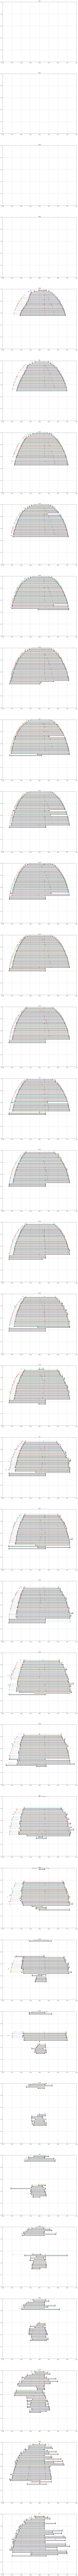

In [9]:
plt.figure(figsize=(15,15*LEN_2))
for i_h, height_plot in enumerate(STEPS_2):
    plt.subplot(LEN_2, 1, i_h+1)
    plt.title(height_plot)
    for k,v in range_list_dict.items():
        if round(k[2], 4)==round(height_plot, 4):
            for vv in v:
                plt.plot(vv, [-k[0]+0.02, -k[0]+0.02], '-o', linewidth=1)
            plt.plot(best_range_dict[k], [-k[0], -k[0]], '-ks', linewidth=3)
    plt.axis([-1,1,0,1])
    plt.grid()

In [10]:

np.save(DATASET_PATH, {"best_range_dict": best_range_dict, "range_list_dict": range_list_dict})